# TEST MODE

In [1]:
TEST_MODE=False

# Seeds

In [2]:
import torch 
import numpy as np
import random
import os

seed=402

os.environ['PYTHONHASHSED']=str(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)


In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Imports

In [4]:
import pandas as pd
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch import nn 
import timm
from torchvision.transforms import v2
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Loading data

In [5]:
train=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
sample=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

train_img_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/train'
test_img_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/test'

In [6]:
if TEST_MODE:
    train = train.sample(n=11000, random_state=seed).reset_index(drop=True)
else:
    train=train

In [7]:
train_data, eval_data=train_test_split(train, test_size=0.15, stratify=train['target'], random_state=seed)

# EDA

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [9]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [10]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


In [12]:
train['diagnosis'].nunique()


9

In [13]:
train['benign_malignant'].nunique()


2

In [14]:
num_feats=train.select_dtypes(include='number').columns.tolist()

cat_feats=train.select_dtypes(include='object').columns.tolist()

### num

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


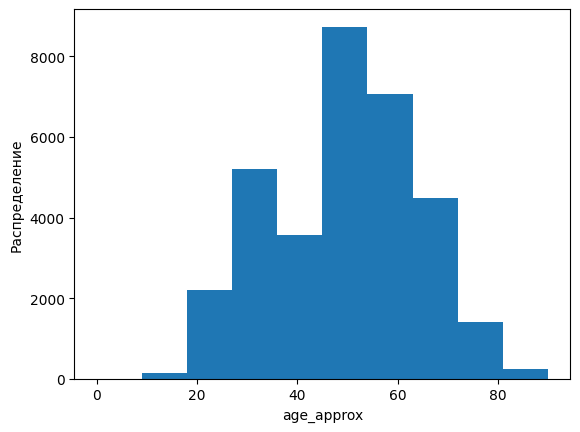

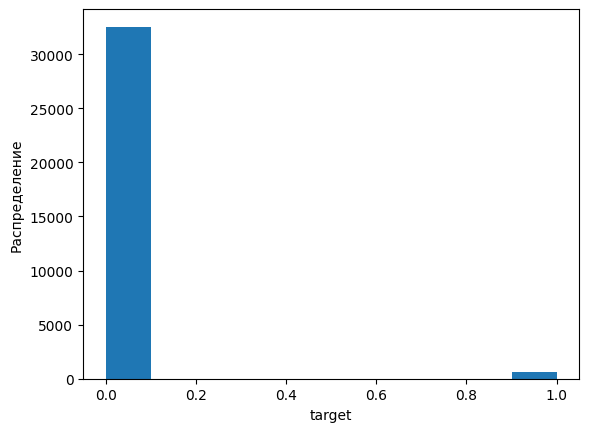

In [15]:
for col in num_feats:
    plt.hist(train[col])
    plt.xlabel(col)
    plt.ylabel('Распределение')
    plt.show()

In [16]:
corr=train[num_feats].corrwith(train['target'])

corr

age_approx    0.086388
target        1.000000
dtype: float64

In [17]:
'''
for col in num_feats:
    plt.hist(test[col])
    plt.xlabel(col)
    plt.ylabel('Распределение')
    plt.show()
    '''

"\nfor col in num_feats:\n    plt.hist(test[col])\n    plt.xlabel(col)\n    plt.ylabel('Распределение')\n    plt.show()\n    "

### same for cat

Cramér’s V (train) — higher = stronger association with target:


benign_malignant                 1.000000
diagnosis                        0.353553
sex                              0.019928
anatom_site_general_challenge    0.018057
patient_id                       0.008125
image_name                       0.000000
dtype: float64

[image_name] Showing top 20 of 33126 categories


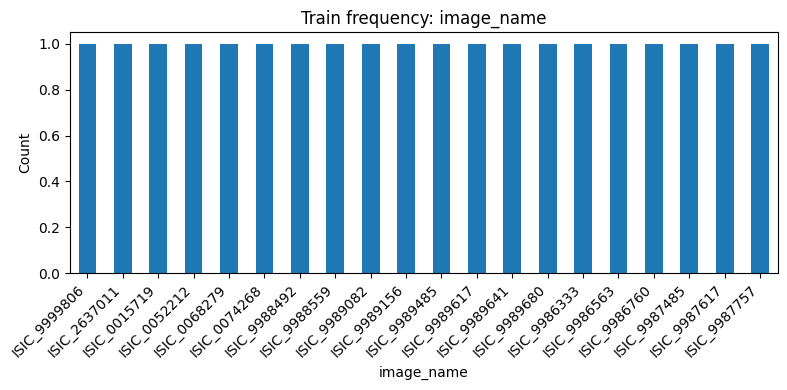

[patient_id] Showing top 20 of 2056 categories


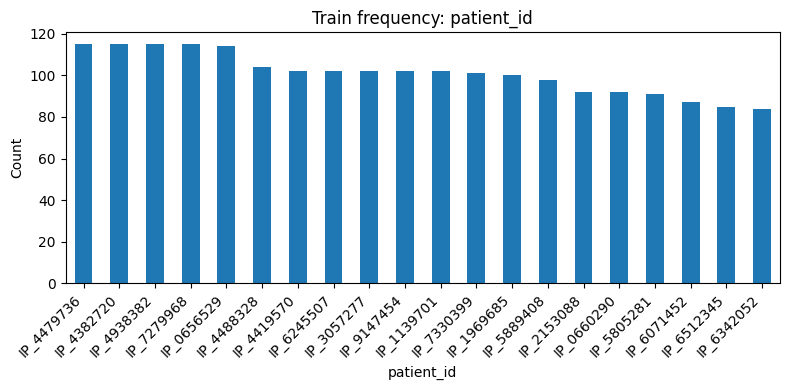

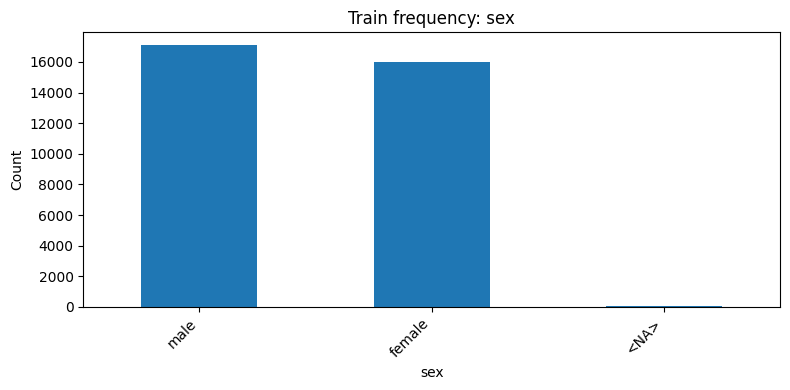

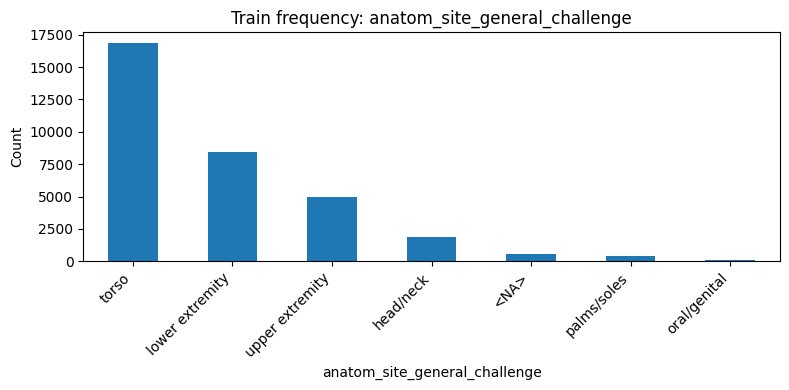

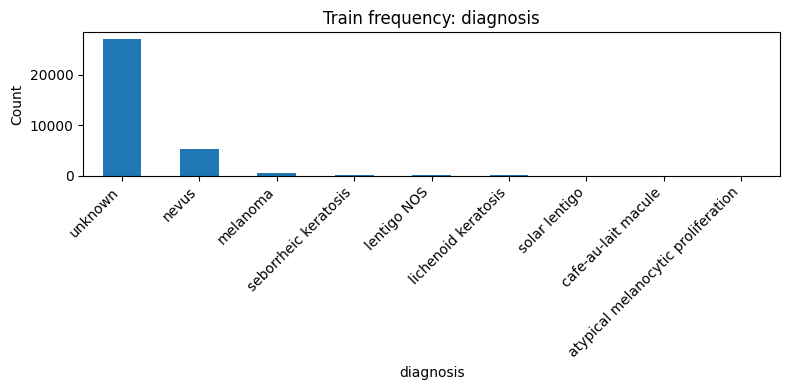

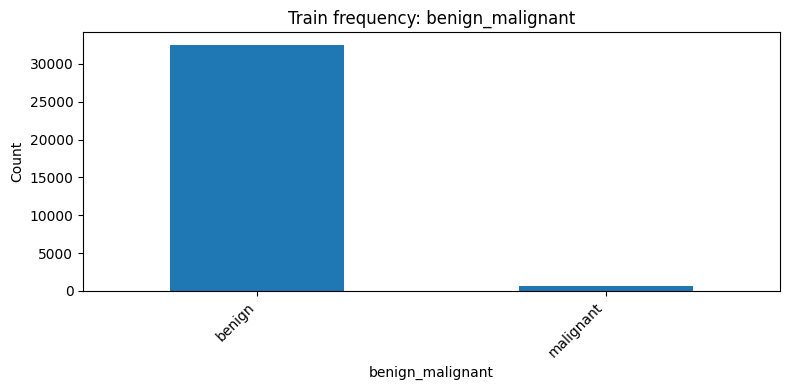

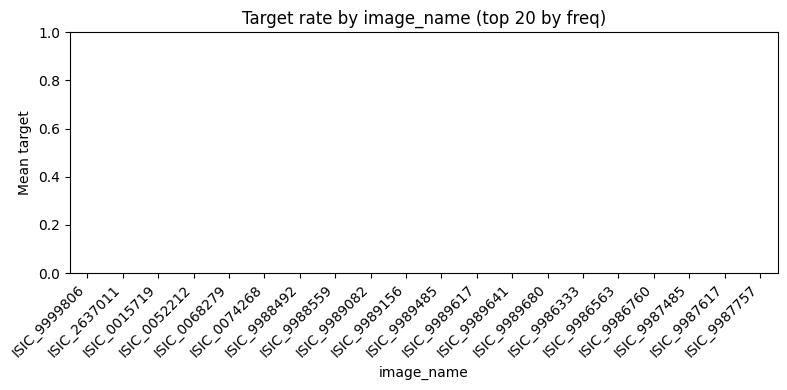

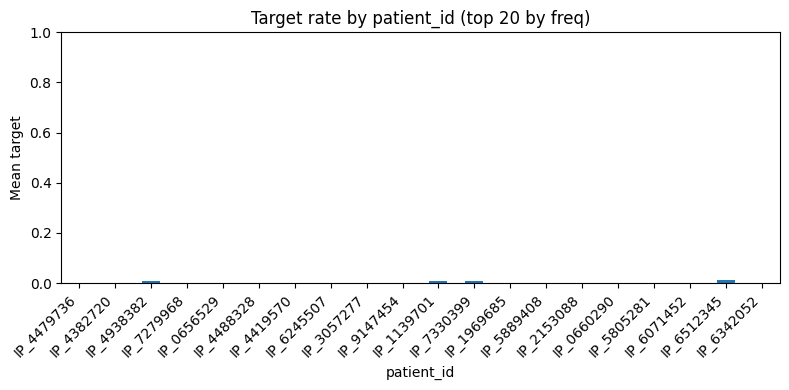

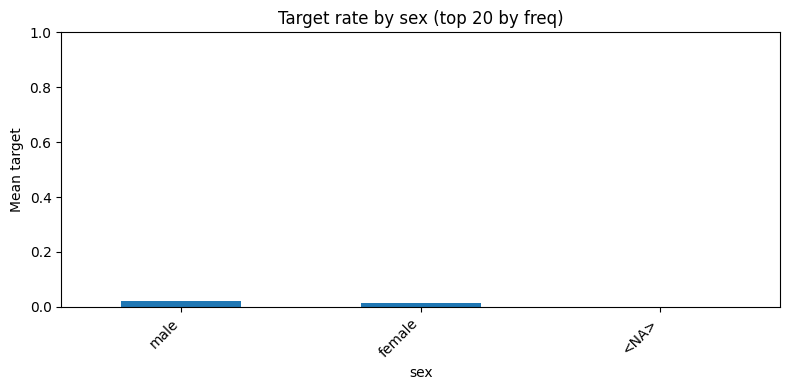

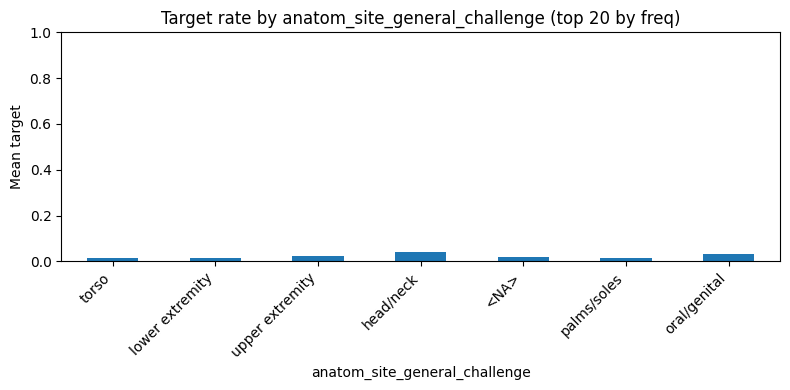

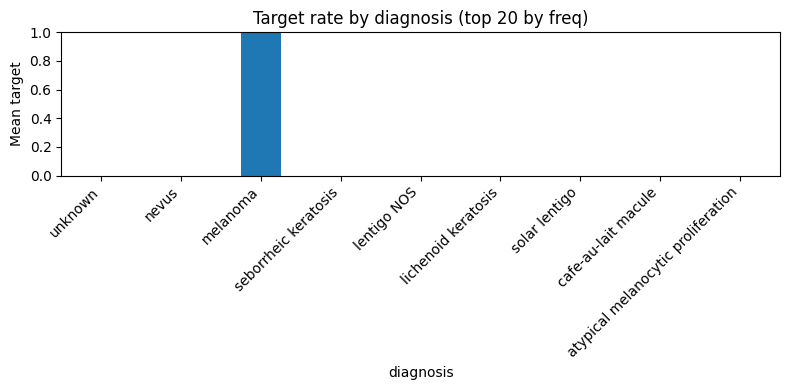

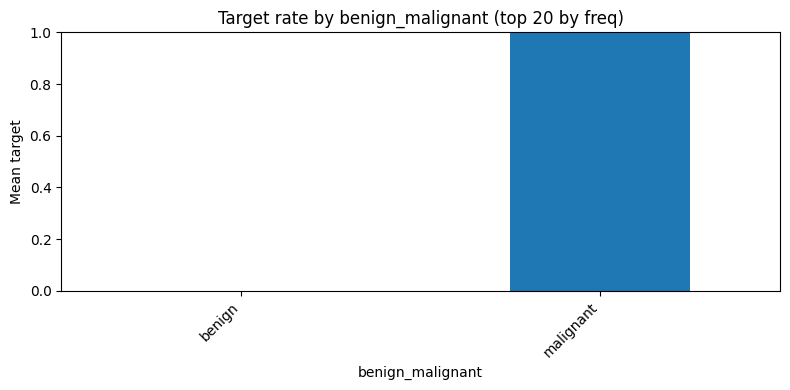

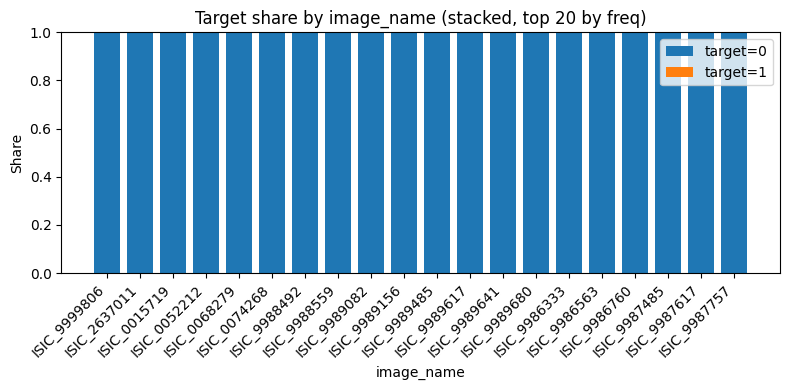

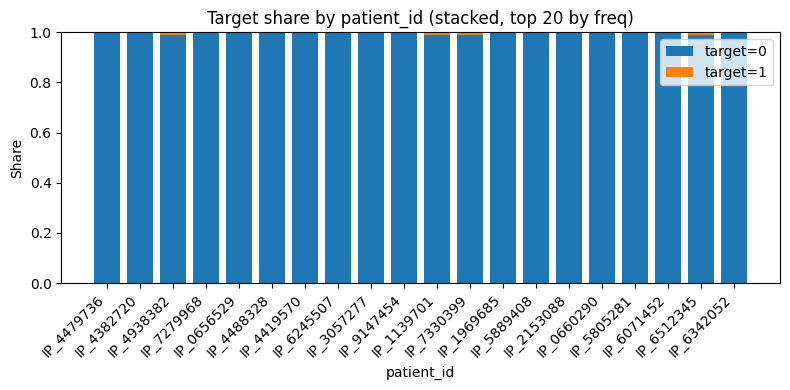

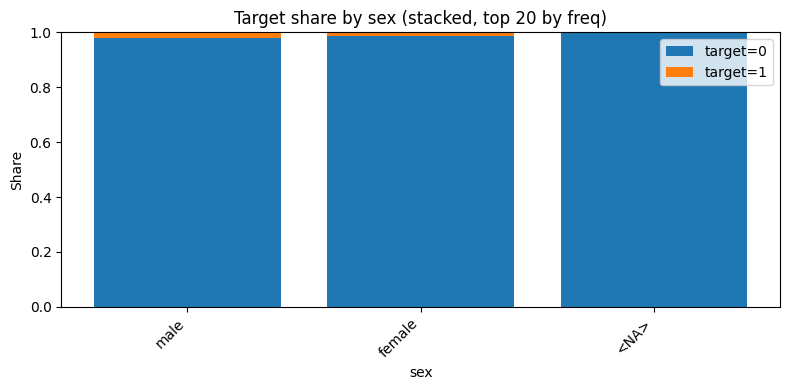

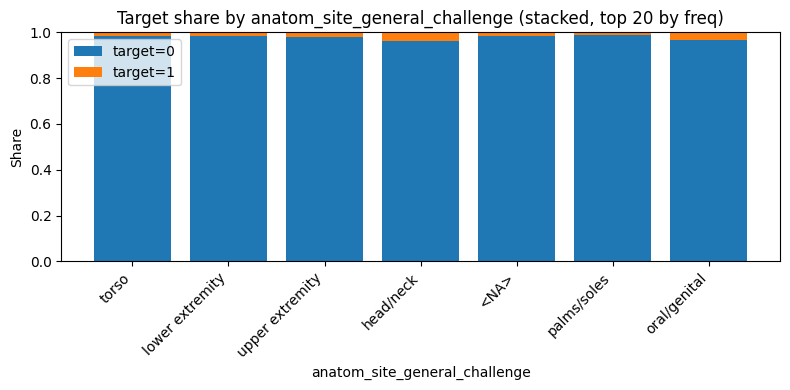

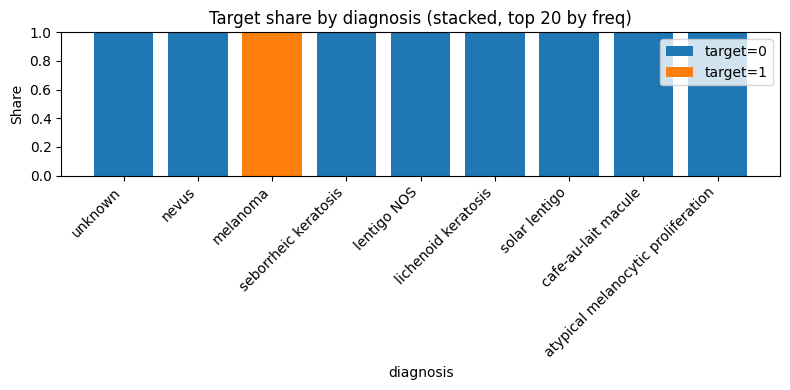

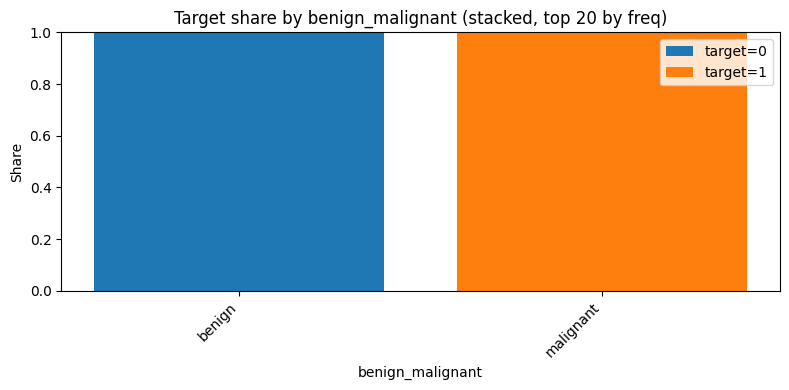


=== image_name: target rate table (top 10 by rate) ===


,count,pos,rate
image_name,,,
ISIC_0149568,1,1,1.0
ISIC_0188432,1,1,1.0
ISIC_0207268,1,1,1.0
ISIC_0232101,1,1,1.0
ISIC_0247330,1,1,1.0
ISIC_0250839,1,1,1.0
ISIC_0272509,1,1,1.0
ISIC_0273046,1,1,1.0
ISIC_0274382,1,1,1.0



=== patient_id: target rate table (top 10 by rate) ===


,count,pos,rate
patient_id,,,
IP_2516168,3,3,1.000000
IP_5399626,5,4,0.800000
IP_3010556,4,3,0.750000
IP_4327880,4,3,0.750000
IP_0585473,3,2,0.666667
IP_0855064,3,2,0.666667
IP_0957064,3,2,0.666667
IP_3541322,3,2,0.666667
IP_4611463,3,2,0.666667



=== sex: target rate table (top 10 by rate) ===


,count,pos,rate
sex,,,
male,17080,364,0.021311
female,15981,220,0.013766
<NA>,65,0,0.000000



=== anatom_site_general_challenge: target rate table (top 10 by rate) ===


,count,pos,rate
anatom_site_general_challenge,,,
head/neck,1855,74,0.039892
oral/genital,124,4,0.032258
upper extremity,4983,111,0.022276
<NA>,527,9,0.017078
torso,16845,257,0.015257
lower extremity,8417,124,0.014732
palms/soles,375,5,0.013333



=== diagnosis: target rate table (top 10 by rate) ===


,count,pos,rate
diagnosis,,,
melanoma,584,584,1.0
unknown,27124,0,0.0
nevus,5193,0,0.0
seborrheic keratosis,135,0,0.0
lentigo NOS,44,0,0.0
lichenoid keratosis,37,0,0.0
solar lentigo,7,0,0.0
atypical melanocytic proliferation,1,0,0.0
cafe-au-lait macule,1,0,0.0



=== benign_malignant: target rate table (top 10 by rate) ===


,count,pos,rate
benign_malignant,,,
malignant,584,584,1.0
benign,32542,0,0.0


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIG ---
# Assumes you already have: train, test, cat_feats (list of categorical columns), and 'target' as binary (0/1)
TOP_N = 20          # how many top categories to show on plots
TARGET_COL = 'target'
NA_LABEL = '<NA>'   # how to display missing categories

# --- HELPERS ---

def _cramers_v_from_crosstab(ct: pd.DataFrame) -> float:
    """
    Bias-corrected Cramér's V for association between a categorical feature and a (binary) target.
    Works without SciPy.
    """
    if ct.size == 0:
        return np.nan

    n = ct.values.sum()
    row_sums = ct.sum(axis=1).values[:, None]
    col_sums = ct.sum(axis=0).values[None, :]
    expected = row_sums * col_sums / n
    # Avoid division by zero
    mask = expected > 0
    chi2 = ((ct.values - expected)**2 / np.where(mask, expected, 1)).sum()
    phi2 = chi2 / n

    r, k = ct.shape
    # Bias correction (Bergsma, 2013)
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1)) if n > 1 else 0
    rcorr = r - (r-1)**2/(n-1) if n > 1 else r
    kcorr = k - (k-1)**2/(n-1) if n > 1 else k
    denom = max((kcorr-1), (rcorr-1), 1e-12)
    return float(np.sqrt(phi2corr / denom))

def cramers_v_series(df: pd.DataFrame, cat_cols, target_col: str) -> pd.Series:
    out = {}
    for c in cat_cols:
        ct = pd.crosstab(df[c].fillna(NA_LABEL), df[target_col])
        out[c] = _cramers_v_from_crosstab(ct)
    return pd.Series(out).sort_values(ascending=False)

def target_rate_table(df: pd.DataFrame, col: str, target_col: str) -> pd.DataFrame:
    g = df.assign(**{col: df[col].fillna(NA_LABEL)}).groupby(col)[target_col]
    tbl = pd.DataFrame({
        'count': g.size(),
        'pos': g.sum(),
    })
    tbl['rate'] = tbl['pos'] / tbl['count'].clip(lower=1)
    tbl = tbl.sort_values(['rate','count'], ascending=[False, False])
    return tbl

def woe_iv_table(df: pd.DataFrame, col: str, target_col: str, event_val=1, eps=1e-6):
    """
    Optional: Weight of Evidence / Information Value per category (binary target).
    Returns (per-category table, IV_total).
    """
    s = df[col].fillna(NA_LABEL)
    t = (df[target_col] == event_val).astype(int)

    agg = pd.DataFrame({'cnt': s.value_counts()}).join(
        t.groupby(s).agg(event='sum')
    )
    agg['nonevent'] = agg['cnt'] - agg['event']

    tot_event = agg['event'].sum()
    tot_nonev = agg['nonevent'].sum()

    agg['dist_event']   = agg['event']   / max(tot_event, eps)
    agg['dist_nonevent']= agg['nonevent']/ max(tot_nonev, eps)
    agg['woe'] = np.log((agg['dist_event'] + eps) / (agg['dist_nonevent'] + eps))
    agg['iv']  = (agg['dist_event'] - agg['dist_nonevent']) * agg['woe']
    iv_total = float(agg['iv'].sum())
    return agg.sort_values('iv', ascending=False), iv_total

# --- 1) SINGLE-NUMBER "CORR-LIKE" METRIC FOR CATS (Cramér’s V) ---
cramers = cramers_v_series(train, cat_feats, TARGET_COL)
print("Cramér’s V (train) — higher = stronger association with target:")
display(cramers)

# --- 2) PLOTS: TRAIN FREQUENCIES (like hist for nums) ---
for col in cat_feats:
    vc = train[col].fillna(NA_LABEL).value_counts().head(TOP_N)
    if vc.shape[0] < train[col].nunique(dropna=True):
        print(f"[{col}] Showing top {TOP_N} of {train[col].nunique(dropna=True)} categories")
    plt.figure(figsize=(8, 4))
    vc.plot(kind='bar')
    plt.title(f"Train frequency: {col}")
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# --- 3) PLOTS: TEST FREQUENCIES (to compare with train) ---
'''
for col in cat_feats:
    vc = test[col].fillna(NA_LABEL).value_counts().head(TOP_N)
    if vc.shape[0] < test[col].nunique(dropna=True):
        print(f"[{col}] (test) Showing top {TOP_N} of {test[col].nunique(dropna=True)} categories")
    plt.figure(figsize=(8, 4))
    vc.plot(kind='bar')
    plt.title(f"Test frequency: {col}")
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
'''
# --- 4) TARGET RATE PER CATEGORY (top-N by count) ---
for col in cat_feats:
    # order by frequency to avoid tiny-cat noise
    freq_order = train[col].fillna(NA_LABEL).value_counts().head(TOP_N).index
    rates = (
        train.assign(**{col: train[col].fillna(NA_LABEL)})
             .groupby(col)[TARGET_COL].mean()
             .reindex(freq_order)
    )
    plt.figure(figsize=(8, 4))
    rates.plot(kind='bar')
    plt.title(f"Target rate by {col} (top {TOP_N} by freq)")
    plt.xlabel(col)
    plt.ylabel(f"Mean {TARGET_COL}")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# --- 5) STACKED SHARE OF TARGET=0/1 BY CATEGORY (top-N by count) ---
for col in cat_feats:
    freq_order = train[col].fillna(NA_LABEL).value_counts().head(TOP_N).index
    share = (
        train.assign(**{col: train[col].fillna(NA_LABEL)})
             .groupby(col)[TARGET_COL]
             .value_counts(normalize=True)
             .unstack(fill_value=0)
             .reindex(freq_order)
    )
    # ensure both 0 and 1 columns exist
    for c in [0,1]:
        if c not in share.columns:
            share[c] = 0.0
    share = share[[0,1]]  # order bars as 0 then 1

    plt.figure(figsize=(8, 4))
    bottom = np.zeros(len(share))
    for cls in share.columns:
        plt.bar(share.index.astype(str), share[cls].values, bottom=bottom, label=f'{TARGET_COL}={cls}')
        bottom += share[cls].values
    plt.title(f"Target share by {col} (stacked, top {TOP_N} by freq)")
    plt.xlabel(col)
    plt.ylabel('Share')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- 6) OPTIONAL: per-feature target tables + IV (quick glance) ---
iv_summary = []
for col in cat_feats:
    tbl = target_rate_table(train, col, TARGET_COL)
    print(f"\n=== {col}: target rate table (top 10 by rate) ===")
    display(tbl.head(10))

    # Uncomment if you want IV as well:
    # iv_tbl, iv = woe_iv_table(train, col, TARGET_COL, event_val=1)
    # iv_summary.append((col, iv))

# If IV computed:
# iv_summary = pd.DataFrame(iv_summary, columns=['feature','IV']).sort_values('IV', ascending=False)
# print("\nInformation Value by feature:")
# display(iv_summary)


# Feature engineering

## NaN filling

In [19]:


def featurize(df):
    df['age_approx_2']=df['age_approx']*df['age_approx']


    
    df['sex_anatom_site_general_challenge']=(df['sex'])+'_' +df['anatom_site_general_challenge']
    df['sex_age_approx']=df['sex']+'_' + str(df['age_approx'])
    df['anatom_site_general_challenge_age_approx']=df['anatom_site_general_challenge']+'_' + str(df['age_approx'])


    #intresting feats:

    

    return df

In [20]:
train_data=featurize(train_data)
eval_data=featurize(eval_data)
test=featurize(test)

# Dataset

In [21]:
class MelanomaDataset1(Dataset):
    def __init__(self, df, img_dir, transforms, is_train):
        self.df=df
        self.img_dir=img_dir
        self.transforms=transforms
        self.is_train=is_train


    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        row=self.df.iloc[idx]
        img_root=row['image_name']
        img_path=os.path.join(self.img_dir, f'{img_root}.jpg')
        image=Image.open(img_path).convert('RGB')

        if self.transforms is not None:
            image=self.transforms(image)

        if self.is_train:
            labels=torch.tensor(row['target'], dtype=torch.long)
            return {
                'image': image,
                'label': labels,
                "idx": idx,
            }
        else:
            return {
                'image': image,
                "idx": idx,
            }
        

In [22]:
import cv2
from PIL import Image

class MelanomaDataset(Dataset):
    def __init__(self, df, img_dir, transforms, is_train, fast_decode=True):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transforms = transforms
        self.is_train = is_train
        self.fast_decode = fast_decode

    def _read_fast(self, path):
        # decode at quarter res; fallback to full if needed
        img = cv2.imread(path, cv2.IMREAD_REDUCED_COLOR_4)
        if img is None:
            img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return Image.fromarray(img)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.img_dir, f"{row['image_name']}.jpg")
        img  = self._read_fast(path) if self.fast_decode else Image.open(path).convert('RGB')
        image = self.transforms(img) if self.transforms is not None else v2.ToImage()(img)

        if self.is_train:
            return {'image': image, 'label': torch.tensor(row['target'], dtype=torch.long)}
        return {'image': image}


## Augmentations

In [23]:
IMG_SIZE=224

In [24]:
train_transforms=v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)),

    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [25]:
eval_transforms=v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)),

    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [26]:
test_transforms=v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)),

    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Making datasets and dataloaders

In [27]:
BATCH_SIZE=64

In [28]:
train_dataset=MelanomaDataset(train_data, train_img_dir, train_transforms,   is_train=True)
eval_dataset=MelanomaDataset(eval_data, train_img_dir,eval_transforms,  is_train=True)
test_dataset=MelanomaDataset(test, test_img_dir,test_transforms,  is_train=False)

In [29]:
train_dataloader=DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, persistent_workers=True, shuffle=True)
eval_dataloader=DataLoader(eval_dataset, batch_size=BATCH_SIZE,num_workers=4,pin_memory=True, persistent_workers=True,  shuffle=False)
test_dataloader=DataLoader(test_dataset, batch_size=BATCH_SIZE,num_workers=4,pin_memory=True, persistent_workers=True,  shuffle=False)

# Vision Model

In [30]:
NUM_EPOCHS=3

In [31]:
MODEL_NAME='seresnext101_32x4d'

In [32]:
model=timm.create_model(MODEL_NAME, pretrained=True, num_classes=2).to(device)

model.safetensors:   0%|          | 0.00/196M [00:00<?, ?B/s]

In [33]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

In [34]:
base_lr=0.01 * (BATCH_SIZE/256)

In [35]:
pos = (train['target'] == 1).sum().item()
neg = (train['target'] == 0).sum().item()

class_weight = torch.tensor([1.0, neg / (pos + 1e-6)], device=device)
criterion = nn.CrossEntropyLoss(weight=class_weight)

In [36]:
NUM_STEPS=len(train_dataloader)*NUM_EPOCHS

In [37]:
WARMUP_STEPS=NUM_STEPS*0.05

In [38]:
optimizer=torch.optim.SGD(model.parameters(), lr=base_lr) #AdamW?

In [39]:
scheduler1=torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1e-3, end_factor=1.00, total_iters=WARMUP_STEPS)

scheduler2=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_STEPS - WARMUP_STEPS, eta_min=base_lr*0.05)

scheduler=torch.optim.lr_scheduler.SequentialLR(
    optimizer, 
    schedulers=[scheduler1, scheduler2],
    milestones=[WARMUP_STEPS]
    
)

## training loop

In [40]:
LOG_EVERY = 50          # show metrics every N batches
EMA_ALPHA = 0.1         # smoothing for the displayed loss

for epoch in range(NUM_EPOCHS):
    model.train()
    training_running_loss = 0.0
    all_probs, all_targets = [], []

    ema_train_loss = None  # NEW
    pbar_train = tqdm(train_dataloader, desc=f'Training {epoch} of {NUM_EPOCHS}: ', leave=False)
    for step, batch in enumerate(pbar_train, start=1):
        optimizer.zero_grad()
        X = batch['image'].to(device)
        y = batch['label'].to(device)

        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()

        batch_loss = loss.detach().item()                              # NEW
        training_running_loss += batch_loss * X.size(0)

        optimizer.step()
        scheduler.step()

        # --- display "now and then"
        ema_train_loss = batch_loss if ema_train_loss is None else (1-EMA_ALPHA)*ema_train_loss + EMA_ALPHA*batch_loss
        if step % LOG_EVERY == 0:                                      # NEW
            current_lr = optimizer.param_groups[0]['lr']
            pbar_train.set_postfix(ema_loss=f"{ema_train_loss:.4f}", lr=f"{current_lr:.2e}")

        probs = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
        all_probs.append(probs)
        all_targets.append(y.detach().cpu().numpy())

    all_probs = np.concatenate(all_probs) if len(all_probs) else np.array([])
    all_targets = np.concatenate(all_targets) if len(all_targets) else np.array([])
    auc = roc_auc_score(all_targets, all_probs)
    print(f"train: loss={training_running_loss / len(train_dataset):.4f}, AUC={auc:.4f}")

    # ===== Eval
    model.eval()
    eval_running_loss = 0.0
    all_probs, all_targets = [], []
    ema_eval_loss = None                                              # NEW
    pbar_eval = tqdm(eval_dataloader, desc=f'Evaluation {epoch} of {NUM_EPOCHS}: ', leave=False)

    with torch.no_grad():
        for step, batch in enumerate(pbar_eval, start=1):
            X = batch['image'].to(device)
            y = batch['label'].to(device)

            logits = model(X)
            loss = criterion(logits, y)
            batch_loss = loss.detach().item()                          # NEW
            eval_running_loss += batch_loss * X.size(0)

            # --- display "now and then"
            ema_eval_loss = batch_loss if ema_eval_loss is None else (1-EMA_ALPHA)*ema_eval_loss + EMA_ALPHA*batch_loss
            if step % LOG_EVERY == 0:                                  # NEW
                pbar_eval.set_postfix(ema_loss=f"{ema_eval_loss:.4f}")

            probs = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
            all_probs.append(probs)
            all_targets.append(y.detach().cpu().numpy())

    all_probs = np.concatenate(all_probs) if len(all_probs) else np.array([])
    all_targets = np.concatenate(all_targets) if len(all_targets) else np.array([])
    auc = roc_auc_score(all_targets, all_probs)
    print(f"valid: loss={eval_running_loss / len(eval_dataset):.4f}, AUC={auc:.4f}")


Training 0 of 3:  15%|█▍        | 65/440 [01:20<07:36,  1.22s/it, ema_loss=0.6579, lr=1.89e-03]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train: loss=0.5182, AUC=0.7976


valid: loss=0.4258, AUC=0.8770


train: loss=0.3578, AUC=0.9187


valid: loss=0.3900, AUC=0.8944


train: loss=0.2205, AUC=0.9756


valid: loss=0.4517, AUC=0.8863


In [41]:
'''
train: loss=0.5168, AUC=0.7576
                                                                 
valid: loss=0.3980, AUC=0.8727
'''

'\ntrain: loss=0.5168, AUC=0.7576\n                                                                 \nvalid: loss=0.3980, AUC=0.8727\n'

In [42]:
'''
for epoch in range(NUM_EPOCHS):
    model.train()
    training_running_loss=0.0
    all_probs, all_targets = [], []
    pbar_train=tqdm(train_dataloader, desc=f'Training {epoch} of {NUM_EPOCHS}: ', leave=False)
    for step, batch in enumerate(pbar_train):
        optimizer.zero_grad()
        X=batch['image'].to(device)
        y=batch['label'].to(device)

        logits=model(X)

        loss=criterion(logits, y)
        loss.backward()

        #training_running_loss+=loss*X.size(0)
        training_running_loss += loss.detach().item() * X.size(0)

        optimizer.step()
        scheduler.step()
        probs=torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()

        all_probs.append(probs)
        all_targets.append(y.detach().cpu().numpy())
            
    all_probs = np.concatenate(all_probs) if len(all_probs) else np.array([])
    all_targets = np.concatenate(all_targets) if len(all_targets) else np.array([])
    auc = roc_auc_score(all_targets, all_probs)

    print(f"train: loss={training_running_loss / len(train_dataset):.4f}, AUC={ auc:.4f}")
    model.eval()
    eval_running_loss =0.0
    all_probs, all_targets = [], []
    pbar_eval=tqdm(eval_dataloader, desc=f'Evaluation {epoch} of {NUM_EPOCHS}: ', leave=False)
    with torch.no_grad():
        for step, batch in enumerate(pbar_eval):
            X=batch['image'].to(device)
            y=batch['label'].to(device)
            logits=model(X)
            
            loss=criterion(logits, y)
            eval_running_loss += loss.detach().item() * X.size(0)
            probs=torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()

            all_probs.append(probs)
            all_targets.append(y.detach().cpu().numpy())
            
        all_probs = np.concatenate(all_probs) if len(all_probs) else np.array([])
        all_targets = np.concatenate(all_targets) if len(all_targets) else np.array([])
        auc = roc_auc_score(all_targets, all_probs)
        
        print(f"valid: loss={eval_running_loss/ len(eval_dataset):.4f}, AUC={auc:.4f}")
'''

'\nfor epoch in range(NUM_EPOCHS):\n    model.train()\n    training_running_loss=0.0\n    all_probs, all_targets = [], []\n    pbar_train=tqdm(train_dataloader, desc=f\'Training {epoch} of {NUM_EPOCHS}: \', leave=False)\n    for step, batch in enumerate(pbar_train):\n        optimizer.zero_grad()\n        X=batch[\'image\'].to(device)\n        y=batch[\'label\'].to(device)\n\n        logits=model(X)\n\n        loss=criterion(logits, y)\n        loss.backward()\n\n        #training_running_loss+=loss*X.size(0)\n        training_running_loss += loss.detach().item() * X.size(0)\n\n        optimizer.step()\n        scheduler.step()\n        probs=torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()\n\n        all_probs.append(probs)\n        all_targets.append(y.detach().cpu().numpy())\n            \n    all_probs = np.concatenate(all_probs) if len(all_probs) else np.array([])\n    all_targets = np.concatenate(all_targets) if len(all_targets) else np.array([])\n    auc = roc_auc_score

# СЕЙВИТЬ ЛОГИТЫ!

In [43]:
!

# Catboost over table data

In [44]:
use_no=['target', 'benign_malignant', 'diagnosis' ]

In [45]:
X_train=train_data.drop(columns=use_no)
X_eval=eval_data.drop(columns=use_no)
y_train=train_data['target']
y_eval=eval_data['target']

cat_feats=X_train.select_dtypes(include='object').columns.tolist()

In [46]:
X_test=test.copy()

In [47]:
model_catboost_base=CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    auto_class_weights='Balanced',
    
)

In [48]:
def prep_cats(df, cats):
    df = df.copy()
    for c in cats:
        df[c] = df[c].astype('object')              # ensure non-numeric type
        df[c] = df[c].fillna('NaN')         # replace NaN
        df[c] = df[c].astype(str)                   # strings only
    return df

X_train = prep_cats(X_train, cat_feats)
X_eval = prep_cats(X_eval, cat_feats)
Xte = prep_cats(test,  cat_feats)

In [49]:
model_catboost_base.fit(X_train, y_train, eval_set=(X_eval, y_eval), cat_features=cat_feats, early_stopping_rounds=300, verbose=100)

0:	test: 0.6491882	best: 0.6491882 (0)	total: 81.3ms	remaining: 1m 21s
100:	test: 0.6931702	best: 0.7205432 (30)	total: 2.72s	remaining: 24.2s
200:	test: 0.7047748	best: 0.7205432 (30)	total: 4.9s	remaining: 19.5s
300:	test: 0.7184002	best: 0.7224488 (256)	total: 8.03s	remaining: 18.6s
400:	test: 0.7093274	best: 0.7224488 (256)	total: 11.3s	remaining: 16.9s
500:	test: 0.7089969	best: 0.7224488 (256)	total: 14.6s	remaining: 14.5s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7224488276
bestIteration = 256

Shrink model to first 257 iterations.


In [50]:
eval_proba = model_catboost_base.predict_proba(Xte)[:, 1]

In [51]:
sub3=pd.DataFrame({
    'image_name': sample['image_name'],
    'target': eval_proba
})

In [52]:
sub3.to_csv('sub.csv', index=False)

In [53]:
#model_catboost_base.

# Extracting embeddings from vision model and doing features 

In [54]:
def extract_embeddings(model, dataloader):
    model.eval()
    emb_list=[]
    with torch.no_grad():
        pbar=tqdm(dataloader, desc='Extracting embeddings: ', leave=False)
        for batch in pbar:
            X=batch['image'].to(device)
            feats=model.forward_features(X)
            emb=model.global_pool(feats)
            emb=torch.nn.functional.normalize(emb, dim=1)
            emb_list.append(emb.cpu())
    return np.concatenate(emb_list, axis=0)


In [55]:
def class_centroid(embeddings, labels, num_class):
    D = embeddings.size(1)
    centroids = torch.zeros(num_class, D, dtype=embeddings.dtype)
    for c in range(num_class):
        mask = (labels == c)
        if mask.any():
            centroids[c] = embeddings[mask].mean(0)
        else:
            centroids[c] = torch.zeros(D, dtype=embeddings.dtype)

    centroids = torch.nn.functional.normalize(centroids, dim=1)
    return centroids

In [56]:
def sim_to_class_centroids(embeddings, centroids):
    if not torch.is_tensor(embeddings):
        embeddings = torch.from_numpy(embeddings)
    if not torch.is_tensor(centroids):
        centroids = torch.from_numpy(centroids)

    embeddings = torch.nn.functional.normalize(embeddings, dim=1)
    centroids  = torch.nn.functional.normalize(centroids,  dim=1)

    sims = embeddings @ centroids.T
    return sims

In [57]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def l2norm(x, eps=1e-12):
    x = x.astype(np.float32)
    n = np.linalg.norm(x, axis=1, keepdims=True) + eps
    return x / n

def knn_geom_features(emb, k=32):
   
    emb = l2norm(emb)

    nn = NearestNeighbors(n_neighbors=k, metric='cosine')
    nn.fit(emb)
    dists, idxs = nn.kneighbors(emb, return_distance=True)
    sims = 1.0 - dists

    feats = []
    for sims_i in sims:
        maxsim  = sims_i[0]
        meansim = sims_i.mean()
        stdsim  = sims_i.std()
        kthsim  = sims_i[-1]
        ratio15 = sims_i[0] / (sims_i[4] + 1e-6) if k >= 5 else sims_i[0]
        feats.append([maxsim, meansim, stdsim, kthsim, ratio15])

    feats = np.array(feats, dtype=np.float32)
    colnames = ['knn_maxsim', 'knn_meansim', 'knn_stdsim', 'knn_kthsim', 'knn_ratio1_5']
    return feats, colnames

# Catboost over all features 

# Submission from all kinds of models that we ve done 

# TTA 

In [58]:
def tta_views(x):
    # x: (B, C, H, W) already resized+normalized
    return [
        x,                                         # identity
        torch.flip(x, dims=[-1]),                  # hflip
        torch.flip(x, dims=[-2]),                  # vflip
        torch.rot90(x, k=1, dims=(-2, -1)),        # 90°
        torch.rot90(x, k=2, dims=(-2, -1)),        # 180°
        torch.rot90(x, k=3, dims=(-2, -1)),        # 270°
    ]

model.eval()
test_probs, test_names = [], []

with torch.no_grad():
    pbar = tqdm(test_dataloader, desc="test", leave=False)
    for batch in pbar:
        x = batch["image"].to(device, non_blocking=True)

        views = tta_views(x)
        x_tta = torch.cat(views, dim=0)

        logits = model(x_tta)

        T = len(views)
        B = x.shape[0]
        C = logits.shape[1] if logits.ndim == 2 else 1
        logits = logits.view(T, B, C).mean(dim=0)

        probs = torch.softmax(logits, dim=1)[:, 1]


        test_probs.append(probs.float().cpu().numpy())
        #test_names.extend(batch["image_name"])

test_probs = np.concatenate(test_probs, axis=0)


In [59]:
sub=pd.DataFrame({
    'image_name': sample['image_name'],
    'target': test_probs
})

In [60]:
sub.to_csv('submission.csv', index=False)

In [61]:
test_probs=[]
model.eval()
with torch.no_grad():
    pbar = tqdm(test_dataloader, desc="test", leave=True)
    for batch in pbar:
        x = batch["image"].to(device, non_blocking=True)
        logits = model(x)                     
        probs  = torch.softmax(logits, 1)[:, 1]
        test_probs.append(probs.float().cpu().numpy())
        
test_probs2 = np.concatenate(test_probs, axis=0)

test: 100%|██████████| 172/172 [02:22<00:00,  1.21it/s]


In [62]:
sub2=pd.DataFrame({
    'image_name': sample['image_name'],
    'target': test_probs2
})

In [63]:
sub2.to_csv('submission2.csv', index=False)